# Project path planing


In [1]:
!pip install --upgrade tdmclient
!pip install ipython
!pip install shapely

Requirement already up-to-date: tdmclient in c:\users\konstantin dinev\anaconda3\lib\site-packages (0.1.21)


## Includes

In [112]:
# Importing libraries
from PIL import Image
from IPython.display import Image, display
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt 
from shapely.geometry import LineString
from shapely.geometry import Point
from itertools import combinations
import networkx as nx
from shapely.geometry import LineString


## Imoprting and scaling image

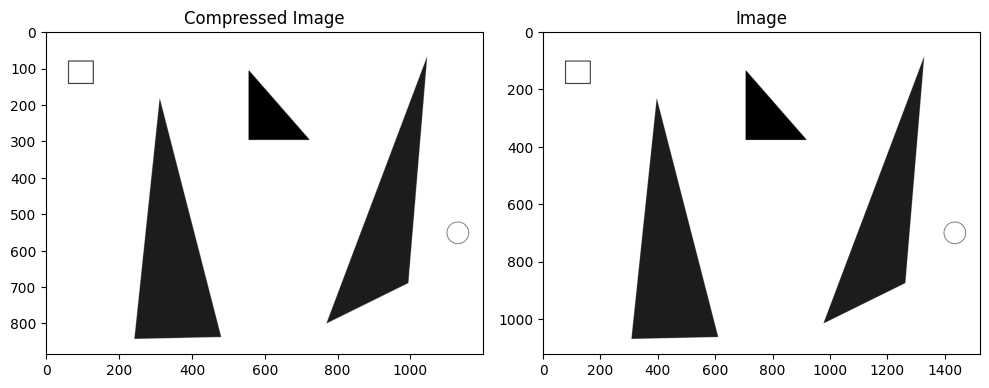

In [113]:
# Load the image
#filename = 'Images/visibility.png'
filename = 'visibility_bis.png'

img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)

# Define the desired dimensions
new_width = 1200
new_height = 1000

# Define a kernel for dilation
kernel = np.ones((3, 3), np.uint8)


# Calculate the scaling factor to maintain aspect ratio
width, height = img.shape[1], img.shape[0]
aspect_ratio = width / height

if width / new_width > height / new_height:
    new_height = int(new_width / aspect_ratio)
else:
    new_width = int(new_height * aspect_ratio)

# Resize the image while preserving the aspect ratio
compressed_img = cv2.resize(img, (new_width, new_height))
comp_height, comp_width = compressed_img.shape

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Display the first image
axes[0].imshow(compressed_img, cmap='gray')
axes[0].set_title('Compressed Image')
axes[0].axis('on')

# Display the second image (other_image)
axes[1].imshow(img, cmap='gray')
axes[1].set_title('Image')
axes[1].axis('on')

plt.tight_layout()
plt.show()

## Filtering and enhancing edges

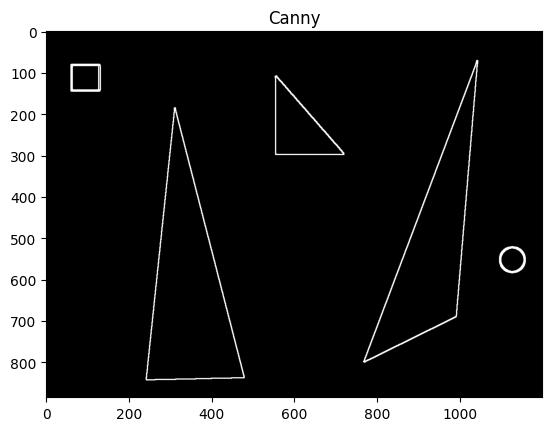

In [114]:
lower_threshold = 100
upper_threshold = 150
aperture_size = 7 # Increase if want more details

canny_img = cv2.Canny(compressed_img, lower_threshold, upper_threshold, apertureSize=aperture_size, L2gradient = True)
# Apply dilation to make edges thicker
dilated_edges = cv2.dilate(canny_img, kernel, iterations=1)

# Save the enhanced edges image
plt.imshow(dilated_edges, cmap='gray');
plt.title('Canny'); plt.axis('on');

## Using contour for detecting the edges of the vertices

In [115]:
triangle_vertices = []
triangle_edges = []

(contours, _) = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

def detectShape(c):          #Function to determine type of polygon on basis of number of sides
       shape = 'unknown' 
       peri=cv2.arcLength(cnt,True) 
       vertices = cv2.approxPolyDP(cnt, 0.02 * peri, True)
       sides = len(vertices) 
       if (sides == 3): 
            shape='triangle' 
       elif(sides==4): 
             x,y,w,h=cv2.boundingRect(cnt)
             aspectratio=float(w)/h 
             if (aspectratio==1):
                   shape='square'
             else:
                   shape="rectangle" 
       elif(sides==5):
            shape='pentagon' 
       elif(sides==6):
            shape='hexagon' 
       elif(sides==8): 
            shape='octagon' 
       elif(sides==10): 
            shape='star'
       else:
           shape='circle' 
       return shape 

for cnt in contours:
    shape = detectShape(cnt)
    print('shape', shape)
    if shape == 'triangle':
        vertices = cv2.approxPolyDP(cnt, 0.02 * cv2.arcLength(cnt, True), True)
        triangle = []  # Store vertices for each triangle
        edges = []  # Store lines for each triangle
        
        for i, vertex in enumerate(vertices):
            x, y = vertex[0]
            triangle.append((x, y))

            next_index = 0 if i == len(vertices) - 1 else i + 1
            next_vertex = vertices[next_index][0]
            cv2.circle(canny_img, (x, y), 5, (255, 0, 0), -1)  
            cv2.putText(canny_img, f'({x},{y})', (x, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0,  0), 2)
                                                                                         
            # Append edges/lines
            edges.append(((x, y), (next_vertex[0], next_vertex[1])))

        triangle_vertices.append(triangle)  # Append the vertices to the list
        triangle_edges.append(edges)  # Append the edges to the list
    # This will be our final goal    
    elif shape == 'octagon':
        # Store circle information
        (Xcent,Ycent), radius = cv2.minEnclosingCircle(cnt)
        (Xcent,Ycent)= (int(Xcent),int(Ycent))
        radius = int(radius)
    # This will be the initial position of the robot starting top left corner   
    elif shape == 'rectangle':
        Xrob,Yrob,Wrob,Hrob=cv2.boundingRect(cnt)
        # Calculate the center of the rectangle
        Xrob_center = Xrob + Wrob // 2
        Yrob_center = Yrob + Hrob // 2
    
    
print((Xcent,Ycent))
print((Xrob_center,Yrob_center))



shape octagon
shape triangle
shape triangle
shape rectangle
shape triangle
(1127, 552)
(96, 113)


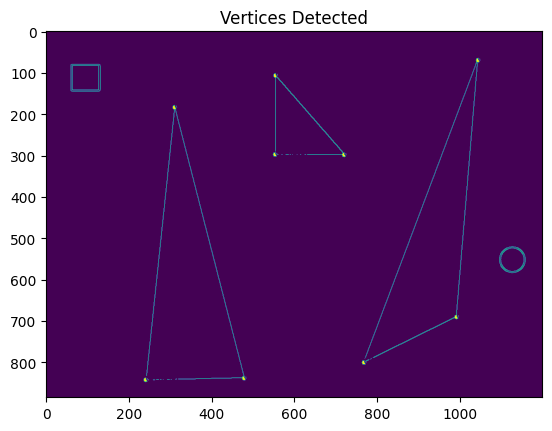

[[(311, 184), (241, 843), (479, 839)], [(555, 107), (554, 298), (721, 299)], [(1045, 70), (769, 801), (993, 691)]]


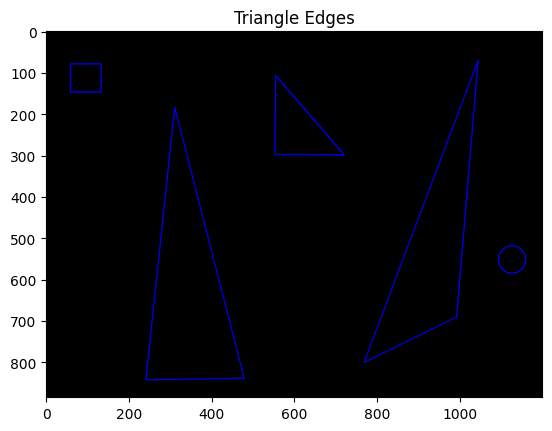

[[((311, 184), (241, 843)), ((241, 843), (479, 839)), ((479, 839), (311, 184))], [((555, 107), (554, 298)), ((554, 298), (721, 299)), ((721, 299), (555, 107))], [((1045, 70), (769, 801)), ((769, 801), (993, 691)), ((993, 691), (1045, 70))]]


In [116]:
# Display the initial image with highlighted vertices
plt.imshow(canny_img)
plt.title('Vertices Detected')
plt.show()
print(triangle_vertices)


# Create a blank image
blank_img = np.zeros((comp_height, comp_width, 3), np.uint8)

# Plot the lines for each triangle
for edges in triangle_edges:
    for edge in edges:
        cv2.line(blank_img, edge[0], edge[1], (0, 0, 255), 2)

# Draw the final position
cv2.circle(blank_img, (Xcent, Ycent), int(radius), (0, 0, 255), 2)


# Draw the robot position
cv2.rectangle(blank_img, (Xrob, Yrob), (Xrob + Wrob, Yrob + Hrob), (0, 0, 255), 2)

plt.imshow(blank_img)
plt.title('Triangle Edges')
plt.axis('on')
plt.show()
print(triangle_edges)

## Adjancy graph

In [124]:
def check_intersection(vertex1, vertex2, triangle1_edges, triangle2_edges):
    line = LineString([vertex1, vertex2])
#    print('line1', line)
    for edge in triangle1_edges:
        for i in range(len(edge)):
            if i != len(edge) - 1:
                edge1 = LineString([edge[i], edge[i + 1]])
            else:
                edge1 = LineString([edge[i], edge[0]])

            if (line.coords[0] in edge1.coords) or (line.coords[1] in edge1.coords):
                #print('The line shares a common point with triangle 1 edge:', edge1)
                break  # Disregard connection if the same vertex is part of both lines

            elif line.intersects(edge1):
                print('Intersection found with triangle 1 edge:', edge1)
                return True  # If an intersection is detected, return True

    for edge in triangle2_edges:
        for i in range(len(edge)):
            if i != len(edge) - 1:
                edge2 = LineString([edge[i], edge[i + 1]])
            else:
                edge2 = LineString([edge[i], edge[0]])

            if (line.coords[0] in edge2.coords) or (line.coords[1] in edge2.coords):
                #print('The line shares a common point with triangle 2 edge:', edge2)
                break  # Disregard connection if the same vertex is part of both lines

            elif line.intersects(edge2):
                print('Intersection found with triangle 2 edge:', edge2)
                return True  # If an intersection is detected, return True

    return False

In [125]:
# Assuming triangle_vertices contains vertex information for each triangle and triangle_edges contains the edges
G = nx.Graph()
G.clear()
for i, triangle1 in enumerate(triangle_vertices):
    for j, triangle2 in enumerate(triangle_vertices):
        if i != j:  # Ensure you're comparing vertices from different triangles
            for vertex1 in triangle1:
                for vertex2 in triangle2:
                    if vertex1 != vertex2:
                        intersection = check_intersection(vertex1, vertex2, triangle_edges[i], triangle_edges[j])
                        print('intersection is',intersection)
                        if not intersection:  # If no intersection add to the edge if intersection = false add
                            print('not intersect the path is valid between V1 and V2')
                            print('number of edges is', G.number_of_edges())
                            G.add_edge(vertex1, vertex2)  # Add edge to the graph
                        # Hanfling the initial position and the goal of the robot
                        circle_intersect_v1 = check_intersection(vertex1, (Xcent,Ycent), triangle_edges[i], triangle_edges[j])
                        circle_intersect_v2 = check_intersection(vertex2, (Xcent,Ycent), triangle_edges[i], triangle_edges[j])
                        robot_intersect_v1 = check_intersection(vertex1, (Xrob_center,Yrob_center), triangle_edges[i], triangle_edges[j])
                        robot_intersect_v2 = check_intersection(vertex2, (Xrob_center,Yrob_center), triangle_edges[i], triangle_edges[j])
                
                        if not circle_intersect_v1:
                            G.add_edge(vertex1, (Xcent,Ycent))
                        if not circle_intersect_v2:
                            G.add_edge(vertex2, (Xcent,Ycent))
                        if not robot_intersect_v1:
                            G.add_edge(vertex1, (Xrob_center, Yrob_center))
                        if not robot_intersect_v2:
                            G.add_edge(vertex2, (Xrob_center, Yrob_center))
                    
# Iterate through each triangle
for i, triangle_edge in enumerate(triangle_edges):
    for edge in triangle_edge:
        G.add_edge(edge[0], edge[1])  # Add each edge to the graph


intersection is False
not intersect the path is valid between V1 and V2
number of edges is 0
Intersection found with triangle 2 edge: LINESTRING (555 107, 554 298)
intersection is False
not intersect the path is valid between V1 and V2
number of edges is 4
Intersection found with triangle 2 edge: LINESTRING (555 107, 554 298)
Intersection found with triangle 1 edge: LINESTRING (311 184, 241 843)
Intersection found with triangle 2 edge: LINESTRING (555 107, 554 298)
intersection is True
Intersection found with triangle 2 edge: LINESTRING (555 107, 554 298)
Intersection found with triangle 2 edge: LINESTRING (555 107, 554 298)
Intersection found with triangle 1 edge: LINESTRING (479 839, 311 184)
intersection is True
Intersection found with triangle 1 edge: LINESTRING (479 839, 311 184)
Intersection found with triangle 1 edge: LINESTRING (479 839, 311 184)
intersection is True
Intersection found with triangle 1 edge: LINESTRING (479 839, 311 184)
Intersection found with triangle 1 edge: 

intersection is False
not intersect the path is valid between V1 and V2
number of edges is 25
Intersection found with triangle 1 edge: LINESTRING (1045 70, 769 801)
Intersection found with triangle 2 edge: LINESTRING (555 107, 554 298)
Intersection found with triangle 2 edge: LINESTRING (554 298, 721 299)
intersection is True
Intersection found with triangle 1 edge: LINESTRING (993 691, 1045 70)
Intersection found with triangle 1 edge: LINESTRING (1045 70, 769 801)
intersection is False
not intersect the path is valid between V1 and V2
number of edges is 25
Intersection found with triangle 1 edge: LINESTRING (993 691, 1045 70)
Intersection found with triangle 1 edge: LINESTRING (1045 70, 769 801)
intersection is False
not intersect the path is valid between V1 and V2
number of edges is 25
Intersection found with triangle 1 edge: LINESTRING (993 691, 1045 70)
Intersection found with triangle 1 edge: LINESTRING (1045 70, 769 801)
Intersection found with triangle 2 edge: LINESTRING (555 1

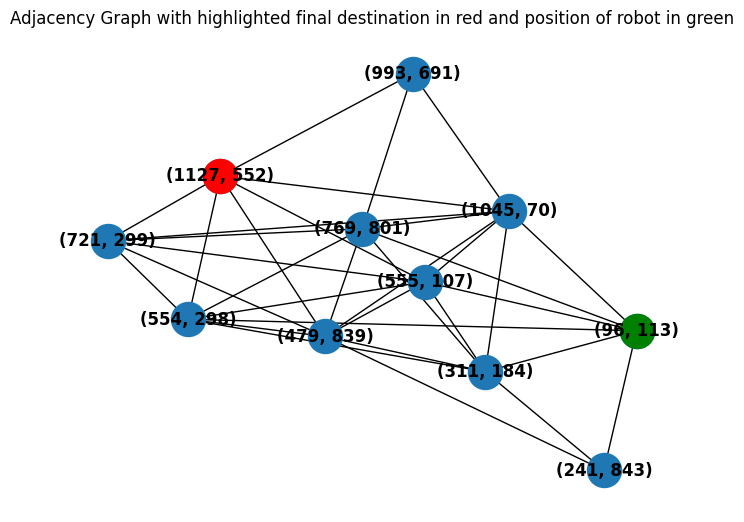

In [121]:
# Draw the graph
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=600, font_weight='bold')
# Draw the highlighted vertex of position of robot and goal position  in a different color
nx.draw_networkx_nodes(G, pos, nodelist=[(Xcent, Ycent)], node_size=600, node_color='red')
nx.draw_networkx_nodes(G, pos, nodelist=[(Xrob_center, Yrob_center)], node_size=600, node_color='green')

plt.title('Adjacency Graph with highlighted final destination in red and position of robot in green')
plt.show()


In [111]:
# Calculate Euclidean distances between connected vertices
euclidean_distances = {}
for u, v in G.edges:
    # Extract coordinates of the vertices (u and v)
    x1, y1 = u
    x2, y2 = v

    # Calculate Euclidean distance between the vertices
    distance = ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5

    # Store the calculated Euclidean distance in the dictionary
    euclidean_distances[(u, v)] = distance

# Output the Euclidean distances
print(euclidean_distances)
print(len(euclidean_distances))

{((311, 184), (555, 107)): 255.86129054626454, ((311, 184), (96, 113)): 226.4199637841151, ((311, 184), (554, 298)): 268.41199675126296, ((311, 184), (1045, 70)): 742.8001077005846, ((311, 184), (769, 801)): 768.4093960903914, ((311, 184), (241, 843)): 662.7073260497427, ((311, 184), (479, 839)): 676.201892928436, ((555, 107), (1127, 552)): 724.7130466605386, ((555, 107), (96, 113)): 459.03921401117793, ((555, 107), (479, 839)): 735.9347797189639, ((555, 107), (1045, 70)): 491.3949531690369, ((555, 107), (554, 298)): 191.0026177831079, ((555, 107), (721, 299)): 253.81095327034254, ((1127, 552), (554, 298)): 626.7734838041571, ((1127, 552), (721, 299)): 478.37746602447737, ((1127, 552), (479, 839)): 708.7122123965411, ((1127, 552), (1045, 70)): 488.92535217556474, ((1127, 552), (993, 691)): 193.07252523339514, ((96, 113), (241, 843)): 744.2613788179526, ((96, 113), (1045, 70)): 949.9736838460316, ((96, 113), (769, 801)): 962.4307767315008, ((96, 113), (554, 298)): 493.9524268591055, ((5